#

🌲 RANDOM FOREST WITH PROPER CROSS-VALIDATION & GRID SEARCH

📂 Loading data...
✅ Total samples: 494
✅ Class distribution: Counter({'positive': 254, 'negative': 133, 'neutral': 107})
✅ Number of classes: 3
✅ Classes: ['negative' 'neutral' 'positive']

📊 STEP 1: Initial 80-20 Train-Test Split

✅ Training set: 395 samples (80.0%)
✅ Test set: 99 samples (20.0%)

Training set distribution: Counter({2: 203, 0: 106, 1: 86})
Test set distribution: Counter({2: 51, 0: 27, 1: 21})

🔤 STEP 2: TF-IDF Vectorization (Training Set Only)

⏳ Fitting TF-IDF on training data...
✅ Training features shape: (395, 1721)
✅ Test features shape: (99, 1721)
✅ Vocabulary size: 1721

🔧 STEP 3: Define Hyperparameter Grid

📋 Hyperparameter Grid:
   n_estimators: [50, 100, 200]
   max_depth: [10, 20, 30, None]
   min_samples_split: [2, 5, 10]
   min_samples_leaf: [1, 2, 4]
   max_features: ['sqrt', 'log2']
   bootstrap: [True]
   class_weight: ['balanced', None]

🔢 Total combinations to test: 432

🔍 STEP 4: Grid Search

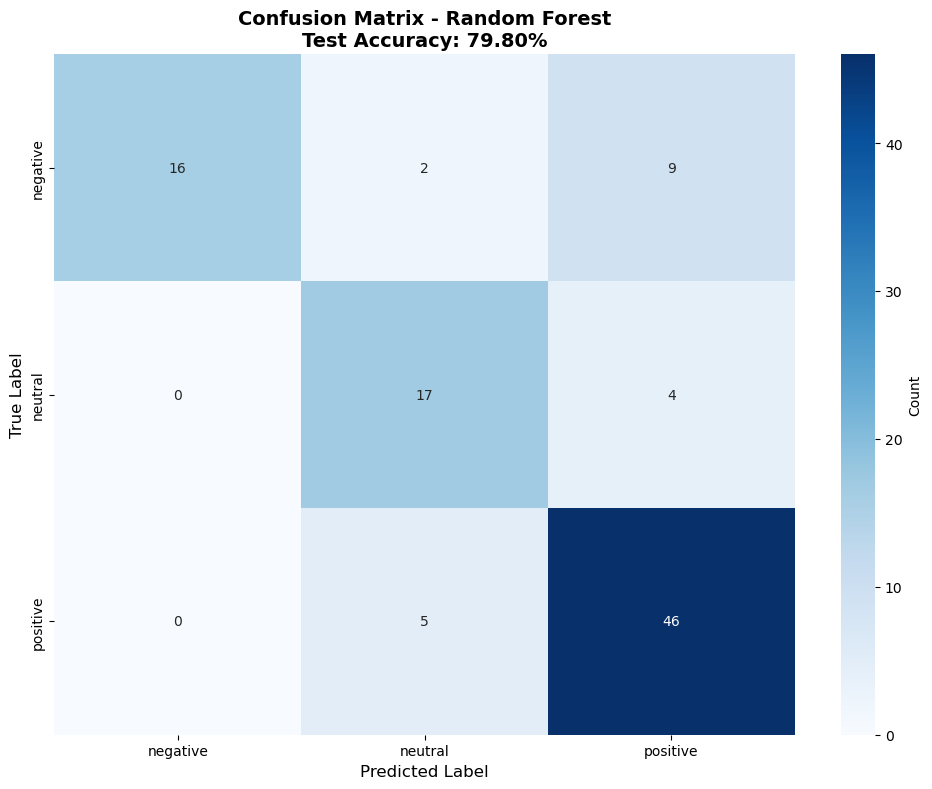

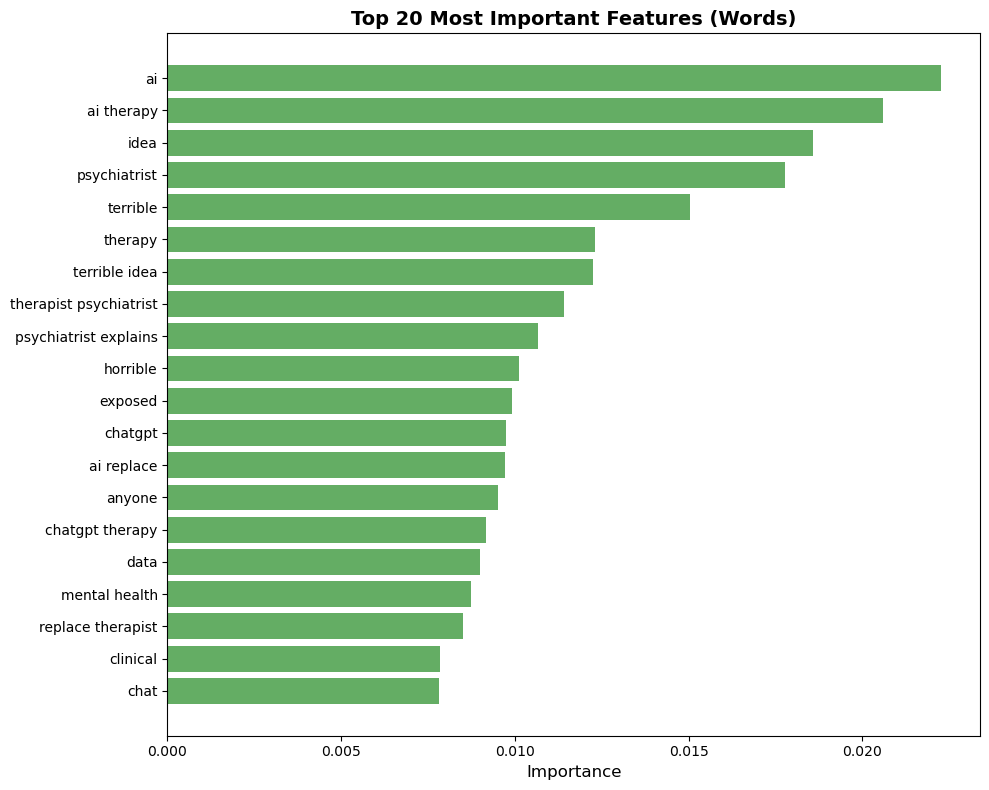

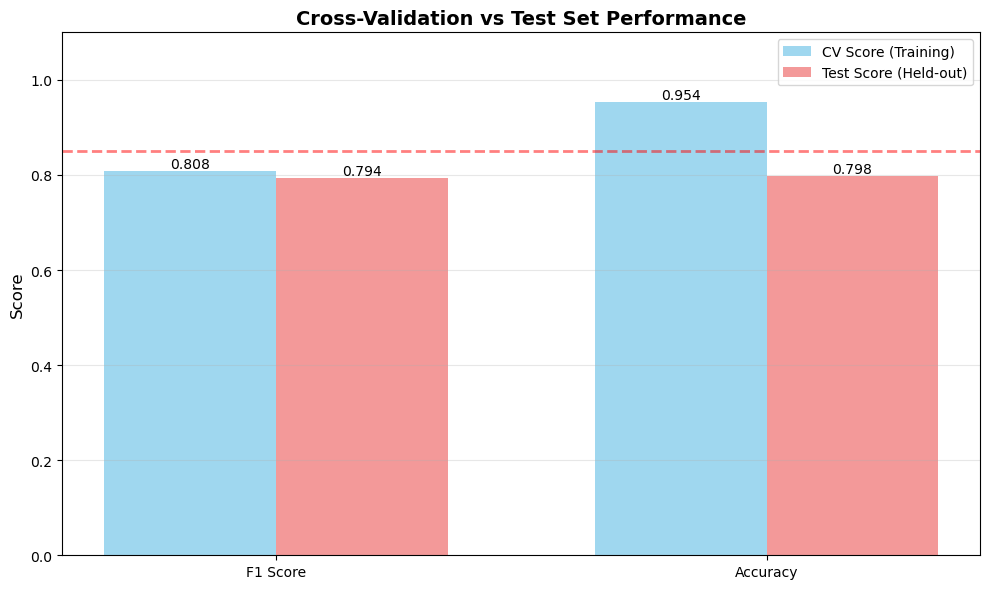

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, f1_score, precision_score, 
                            recall_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import Counter
import warnings
import time
warnings.filterwarnings('ignore')

print("=" * 80)
print("🌲 RANDOM FOREST WITH PROPER CROSS-VALIDATION & GRID SEARCH")
print("=" * 80)

# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("\n📂 Loading data...")
df = pd.read_excel("labels_sentences_FINAL_ROUND2.xlsx")
X = df['sentences_clean'].values
y = df['labels'].values

print(f"✅ Total samples: {len(df)}")
print(f"✅ Class distribution: {Counter(y)}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"✅ Number of classes: {len(label_encoder.classes_)}")
print(f"✅ Classes: {label_encoder.classes_}")

# ============================================================================
# 2. INITIAL 80-20 TRAIN-TEST SPLIT
# ============================================================================
print("\n" + "=" * 80)
print("📊 STEP 1: Initial 80-20 Train-Test Split")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\n✅ Training set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"✅ Test set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")
print(f"\nTraining set distribution: {Counter(y_train)}")
print(f"Test set distribution: {Counter(y_test)}")

# ============================================================================
# 3. VECTORIZATION (fit only on training data)
# ============================================================================
print("\n" + "=" * 80)
print("🔤 STEP 2: TF-IDF Vectorization (Training Set Only)")
print("=" * 80)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.85
)

print("\n⏳ Fitting TF-IDF on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✅ Training features shape: {X_train_tfidf.shape}")
print(f"✅ Test features shape: {X_test_tfidf.shape}")
print(f"✅ Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# ============================================================================
# 4. DEFINE HYPERPARAMETER GRID
# ============================================================================
print("\n" + "=" * 80)
print("🔧 STEP 3: Define Hyperparameter Grid")
print("=" * 80)

param_grid = {
    'n_estimators': [50, 100, 200],           # Number of trees
    'max_depth': [10, 20, 30, None],          # Maximum depth of trees
    'min_samples_split': [2, 5, 10],          # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],            # Minimum samples at leaf
    'max_features': ['sqrt', 'log2'],         # Features to consider for split
    'bootstrap': [True],                       # Bootstrap sampling
    'class_weight': ['balanced', None]        # Handle class imbalance
}

print("\n📋 Hyperparameter Grid:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\n🔢 Total combinations to test: {total_combinations}")

# ============================================================================
# 5. GRID SEARCH WITH 5-FOLD CROSS-VALIDATION
# ============================================================================
print("\n" + "=" * 80)
print("🔍 STEP 4: Grid Search with 5-Fold Cross-Validation")
print("=" * 80)
print("\n⚙️  This will:")
print("   1. For each hyperparameter combination:")
print("      - Split training data into 5 folds")
print("      - Train on 4 folds, validate on 1 fold")
print("      - Repeat 5 times (each fold as validation once)")
print("      - Calculate average F1 score across 5 folds")
print("   2. Select combination with highest average F1")
print()

# Setup 5-fold cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Setup Grid Search
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',          # Optimize for weighted F1 score
    n_jobs=-1,                       # Use all CPU cores
    verbose=2,                       # Show progress
    return_train_score=True
)

print("⏳ Starting Grid Search... This may take several minutes...\n")
start_time = time.time()

# Fit grid search on TRAINING DATA ONLY
grid_search.fit(X_train_tfidf, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n✅ Grid Search completed in {elapsed_time/60:.2f} minutes!")

# ============================================================================
# 6. BEST HYPERPARAMETERS & CV RESULTS
# ============================================================================
print("\n" + "=" * 80)
print("🏆 STEP 5: Best Hyperparameters from Grid Search")
print("=" * 80)

print("\n🥇 Best hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best CV F1 Score (avg of 5 folds): {grid_search.best_score_:.4f}")

# Get detailed CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

print("\n📈 Top 5 Hyperparameter Combinations:")
print("-" * 80)
top5_results = cv_results.head(5)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
for idx, row in top5_results.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"   F1 Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Params: {row['params']}")

# Save detailed CV results
cv_results_export = cv_results[[
    'params', 'mean_test_score', 'std_test_score', 
    'mean_train_score', 'std_train_score', 'rank_test_score'
]].head(20)
cv_results_export.to_excel('grid_search_cv_results.xlsx', index=False)
print("\n💾 Saved: grid_search_cv_results.xlsx (Top 20 combinations)")

# ============================================================================
# 7. TRAIN FINAL MODEL ON ENTIRE TRAINING SET
# ============================================================================
print("\n" + "=" * 80)
print("🎯 STEP 6: Train Final Model with Best Hyperparameters")
print("=" * 80)

print("\n⏳ Training final Random Forest model on ENTIRE training set...")
best_rf_model = grid_search.best_estimator_
# Model is already trained on full training set by GridSearchCV
# But let's explicitly retrain for clarity
best_rf_model.fit(X_train_tfidf, y_train)
print("✅ Final model trained!")

# ============================================================================
# 8. EVALUATE ON HELD-OUT TEST SET
# ============================================================================
print("\n" + "=" * 80)
print("🎯 STEP 7: Final Evaluation on Held-Out Test Set")
print("=" * 80)

print("\n⏳ Making predictions on test set...")
y_test_pred = best_rf_model.predict(X_test_tfidf)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

print("\n" + "=" * 80)
print("📊 FINAL TEST SET PERFORMANCE")
print("=" * 80)
print(f"\n✅ Accuracy:  {test_accuracy*100:.2f}%")
print(f"✅ F1 Score:  {test_f1:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall:    {test_recall:.4f}")

if test_accuracy >= 0.85:
    print("\n🎉🎉🎉 EXCELLENT! Achieved 85%+ accuracy! 🎉🎉🎉")
elif test_accuracy >= 0.80:
    print(f"\n✅ Great performance! Only {(0.85-test_accuracy)*100:.1f}% away from 85% target.")
else:
    print(f"\n💪 Good start! {(0.85-test_accuracy)*100:.1f}% away from 85% target.")

# ============================================================================
# 9. DETAILED CLASSIFICATION REPORT
# ============================================================================
print("\n" + "=" * 80)
print("📋 DETAILED CLASSIFICATION REPORT (Test Set)")
print("=" * 80)
print("\n" + classification_report(
    y_test, y_test_pred,
    target_names=label_encoder.classes_,
    digits=4
))

# ============================================================================
# 10. CONFUSION MATRIX
# ============================================================================
print("\n" + "=" * 80)
print("📊 CONFUSION MATRIX")
print("=" * 80)

cm = confusion_matrix(y_test, y_test_pred)
print("\n", cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Random Forest\nTest Accuracy: {test_accuracy*100:.2f}%',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('random_forest_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: random_forest_confusion_matrix.png")

# ============================================================================
# 11. FEATURE IMPORTANCE
# ============================================================================
print("\n" + "=" * 80)
print("🔍 FEATURE IMPORTANCE (Top 20 Words)")
print("=" * 80)

# Get feature importances
feature_importance = best_rf_model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create dataframe and sort
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n📊 Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Most Important Features (Words)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('random_forest_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: random_forest_feature_importance.png")

# ============================================================================
# 12. SAVE TEST PREDICTIONS
# ============================================================================
print("\n" + "=" * 80)
print("💾 SAVING RESULTS")
print("=" * 80)

# Create predictions dataframe
test_predictions_df = pd.DataFrame({
    'sentence': X_test,
    'true_label': label_encoder.inverse_transform(y_test),
    'predicted_label': label_encoder.inverse_transform(y_test_pred),
    'correct': y_test == y_test_pred
})

test_predictions_df.to_excel('random_forest_test_predictions.xlsx', index=False)
print("\n✅ Saved: random_forest_test_predictions.xlsx")

# Save misclassified samples
misclassified = test_predictions_df[~test_predictions_df['correct']]
print(f"\n⚠️  Misclassified samples: {len(misclassified)} ({len(misclassified)/len(test_predictions_df)*100:.1f}%)")

if len(misclassified) > 0:
    misclassified.to_excel('random_forest_misclassified.xlsx', index=False)
    print("✅ Saved: random_forest_misclassified.xlsx")
    
    print("\n⚠️  Sample Misclassifications:")
    for idx, row in misclassified.head(5).iterrows():
        print(f"\n   Sentence: {row['sentence'][:70]}...")
        print(f"   True: {row['true_label']} | Predicted: {row['predicted_label']}")

# Save feature importance
importance_df.to_excel('random_forest_feature_importance.xlsx', index=False)
print("\n✅ Saved: random_forest_feature_importance.xlsx")

# ============================================================================
# 13. COMPARISON: CV SCORE vs TEST SCORE
# ============================================================================
print("\n" + "=" * 80)
print("📊 CROSS-VALIDATION vs TEST SET COMPARISON")
print("=" * 80)

print(f"\n🔄 Best CV F1 Score (5-fold on training):  {grid_search.best_score_:.4f}")
print(f"🎯 Test Set F1 Score (held-out):           {test_f1:.4f}")
print(f"📉 Difference:                             {abs(grid_search.best_score_ - test_f1):.4f}")

if abs(grid_search.best_score_ - test_f1) < 0.03:
    print("\n✅ Good generalization! CV and test scores are very close.")
elif abs(grid_search.best_score_ - test_f1) < 0.05:
    print("\n✅ Acceptable generalization. Minor difference between CV and test.")
else:
    print("\n⚠️  Larger gap between CV and test. Model may be overfitting.")

# ============================================================================
# 14. VISUALIZE CV vs TEST PERFORMANCE
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

metrics = ['F1 Score', 'Accuracy']
cv_scores = [grid_search.best_score_, 
             cv_results.loc[cv_results['rank_test_score'] == 1, 'mean_train_score'].values[0]]
test_scores = [test_f1, test_accuracy]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, cv_scores, width, label='CV Score (Training)', 
               color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Score (Held-out)', 
               color='lightcoral', alpha=0.8)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Cross-Validation vs Test Set Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='85% Target', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('random_forest_cv_vs_test.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: random_forest_cv_vs_test.png")

# ============================================================================
# 15. FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 80)

print("\n📋 Summary:")
print(f"   1. Initial split: 80% train ({len(X_train)}), 20% test ({len(X_test)})")
print(f"   2. Grid search tested: {total_combinations} combinations")
print(f"   3. Each combination: 5-fold CV on training set")
print(f"   4. Best CV F1: {grid_search.best_score_:.4f}")
print(f"   5. Final test accuracy: {test_accuracy*100:.2f}%")
print(f"   6. Final test F1: {test_f1:.4f}")

print("\n📁 Generated Files:")
print("   1. grid_search_cv_results.xlsx - All CV results")
print("   2. random_forest_confusion_matrix.png - Confusion matrix")
print("   3. random_forest_feature_importance.png - Top features")
print("   4. random_forest_test_predictions.xlsx - All test predictions")
print("   5. random_forest_misclassified.xlsx - Misclassified samples")
print("   6. random_forest_feature_importance.xlsx - Full feature ranking")
print("   7. random_forest_cv_vs_test.png - Performance comparison")

print("\n🎯 Best Model Configuration:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print("\n" + "=" * 80)
print("🌲 Random Forest Pipeline Complete! Model ready for deployment.")
print("=" * 80)